# FORCE learning 8/20

In [1]:
import matplotlib.pyplot as plt
import jax.numpy as np
from jax import grad, jit, vmap
from numpy import random
import numpy as onp

from tqdm import tqdm_notebook as tqdm

In [2]:
import seaborn as sns
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})
sns.set_style('ticks')

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [4]:
def keygen(key, nkeys):
  """Generate randomness that JAX can use by splitting the JAX keys.
  Args:
    key : the random.PRNGKey for JAX
    nkeys : how many keys in key generator
  Returns:
    2-tuple (new key for further generators, key generator)
  """
  keys = random.split(key, nkeys+1)
  return keys[0], (k for k in keys[1:])

In [5]:
def print_force(params, fparams, x_t, h_t, z_t, f_t, T):
  """Plot activations and outputs for the Echostate network run."""
  ntoplot = 10
  plt.figure(figsize=(16,16))

  plt.subplot(321)
  plt.plot(time, f_t + 2*onp.arange(0, f_t.shape[1]), 'g')
  plt.plot(time, z_t + 2*onp.arange(0, z_t.shape[1]), 'r');
  plt.xlim((0, T))
  plt.title('Target - f (green), Output - z (red)')
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(122)
  plt.imshow(h_t.T, interpolation=None)
  plt.title('Hidden activations of ESN')
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(323)
  plt.plot(time, h_t[:, 0:ntoplot] + 2*onp.arange(0, ntoplot), 'b')
  plt.xlim((0, T))
  plt.title('%d hidden activations of ESN'%(ntoplot))
  plt.xlabel('Time')
  plt.ylabel('Dimension')

  plt.subplot(325)
  plt.plot(time, onp.sqrt(onp.square(z_t - f_t)), 'c')
  plt.xlim((0, T))
  plt.title('Error - mean absolute error')
  plt.xlabel('Time')
  plt.ylabel('Error')

def plot_params(params):
  """Plot some of the parameters associated with the ESN."""
  plt.figure(figsize=(16,10))
  plt.subplot(221)
  plt.imshow(params['wR'] + onp.dot(params['wF'], params['wO']), 
            interpolation=None); 
  plt.colorbar()
  plt.title('Effective matrix - wR + wF wO')

  plt.subplot(222)
  if params['wO'].shape[0] == 1:
    plt.stem(params['wO'][0,:])
  else:
    plt.imshow(params['wO'], interpolation=None)
    plt.colorbar()
  plt.title('Readout weights - wO');

  x_circ = onp.linspace(-1, 1, 1000)
  y_circ = onp.sqrt(1-x_circ**2)
  evals, _ = onp.linalg.eig(params['wR'])
  plt.subplot(223)
  plt.plot(onp.real(evals), onp.imag(evals), 'o')
  plt.plot(x_circ, y_circ, 'k')
  plt.plot(x_circ, -y_circ, 'k')
  plt.axis('equal')
  plt.title('Eigenvalues of wR')

  evals, _ = onp.linalg.eig(params['wR'] + onp.dot(params['wF'], params['wO']))
  plt.subplot(224)
  plt.plot(onp.real(evals), onp.imag(evals), 'o', color='orange')
  plt.plot(x_circ, y_circ, 'k')
  plt.plot(x_circ, -y_circ, 'k')
  plt.axis('equal');
  plt.title('Eigenvalues of wR + wF wO');

# Sussillo

In [6]:
def random_esn_params(key, u, n, m, tau=1.0, dt=0.1, g=1.0):
  """Generate random RNN parameters
  
  Arguments: 
    u: dim of the input
    n: dim of the hidden state
    m: dim of the output
    tau: "neuronal" time constant
    dt: time between Euler integration updates
    g: scaling of the recurrent matrix in the reservoir

  Returns:
    A dictionary of parameters for the ESN.
  """

  key, skeys = keygen(key, 5)
  hscale = 0.25
  ifactor = 1.0 / np.sqrt(u)
  hfactor = g / np.sqrt(n)
  pfactor = 1.0 / np.sqrt(n)
  ffactor = 1.0 # Feedback factor, keep at 1 for now.
  return {'a0' : random.normal(next(skeys), (n,)) * hscale,
          'wI' : random.normal(next(skeys), (n,u)) * ifactor,
          'wR' : random.normal(next(skeys), (n,n)) * hfactor,
          'wO' : random.normal(next(skeys), (m,n)) * pfactor,
          'wF' : random.normal(next(skeys), (n,m)) * ffactor,
          'dt_over_tau' : dt / tau}


def new_force_params(n, alpha=1.0):
  """Generate new 'parameters' for the RLS learning rule.

  This routine essentially initializes the inverse correlation matrix in RLS.

  Arguments:
    n: dim of hidden state
    alpha: initial learning rate

  Returns: 
    A dictionary with RLS parameters.
  """
  return {'P' : np.eye(n) * alpha}


def esn(x, a, h, z, wI, wR, wF, wO, dtdivtau):
  """Run the continuous-time Echostate network one step.
  
    da/dt = -a + wI x + wR h + wF z

    Arguments:
      x: ndarray of input to ESN
      a: ndarray of activations (pre nonlinearity) from prev time step
      h: ndarray of hidden states from prev time step
      z: ndarray of output from prev time step
      wI: ndarray, input matrix, shape (n, u)
      wR: ndarray, recurrent matrix, shape (n, n)
      wF: ndarray, feedback matrix, shape (n, m)
      wO: ndarray, output matrix, shape (m, n)
      dtdivtau: dt / tau

    Returns: 
      The update to the ESN at this time step.
  """
  dadt = -a + np.dot(wI, x) + np.dot(wR, h) + np.dot(wF, z)
  a = a + dtdivtau * dadt
  h = np.tanh(a)
  z = np.dot(wO, h)
  return a, h, z


def rls(h, z, f, wO, P):
  """Perform the recursive least squares step.
  
    Arguments: 
      h: ndarray of hidden state at current time step
      z: ndarray of output at current time step
      f: ndarray of targets at current time step
      wO: ndarray of output weights, shape (m, n)
      P: ndarray, inverse correlation matrix, shape (n,n)

    Returns: 
      A 2-tuple of the updated wO, and updated P
  
  """
  # update inverse correlation matrix
  k = np.expand_dims(np.dot(P, h), axis=1)
  hPh = np.dot(h.T, k)
  c = 1.0/(1.0 + hPh)
  P = P - np.dot(k*c, k.T)
    
  # update the output weights
  e = np.atleast_2d(z-f)
  dw = np.dot(-c*k, e).T
  return wO + dw, P    

In [7]:
def esn_run_and_train_jax(params, fparams, x_t, f_t=None, do_train=False):
  """Run the Echostate network forward a number of steps the length of x_t.
  
    This implementation uses JAX to build the outer time loop from basic
    Python for loop.

    Arguments: 
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of input time series, shape (t, u)
      f_t: ndarray of target time series, shape (t, m)
      do_train: Should the network be trained on this run? 
    
    Returns:
      4-tuple of params, fparams, h_t, z_t, after running ESN and potentially
        updating the readout vector.  
  """
  # per-example predictions
  a = params['a0']
  h = np.tanh(a)
  wO = params['wO']
  z = np.dot(wO, h)
  if do_train:
    P = fparams['P']
  else:
    P = None
  h_t = []
  z_t = []

  wI = params['wI']
  wR = params['wR']
  wF = params['wF']
  dtdivtau = params['dt_over_tau']
  for tidx, x in enumerate(x_t):
    a, h, z = esn(x, a, h, z, wI, wR, wF, wO, dtdivtau)
    if do_train:
      wO, P = rls(h, z, f_t[tidx], wO, P)
    h_t.append(h)
    z_t.append(z)
  
  if do_train:
    fparams['P'] = P
  params['wO'] = wO
  h_t = np.array(h_t)  
  z_t = np.array(z_t)
  return params, fparams, h_t, z_t


def esn_run_jax(params, x_t):
  """Run the echostate network forward.

    Arguments:
      params: dict of ESN params
      x_t: ndarray of input with shape (t,u)

    Returns: 
      2-tuple of ndarrays with first dim time, the hidden state and the outputs.
  """
  _, _, h_t, z_t  = esn_run_and_train_jax(params, None, x_t, 
                                          None, do_train=False)
  return h_t, z_t

esn_run_jax_jit = jit(esn_run_jax)


def esn_train_jax(params, fparams, x_t, f_t):
  """Run the echostate network forward and also train it.

    Arguments:
      params: dict of ESN params
      fparams: dict of RLS params
      x_t: ndarray of inputs with shape (t,u)
      f_t: ndarray of targets with shape (t,m)

    Returns: 
      4-tuple of updated params, fparams, and also ndarrays with first dim 
        time, the hidden state and the outputs.
  """
  return esn_run_and_train_jax(params, fparams, x_t, f_t, do_train=True)
  
esn_train_jax_jit = jit(esn_train_jax)

In [8]:
# Basic parameters of the Echostate networks
key = random.PRNGKey(0)

T = 30              # total time
u = 1               # number of inputs (didn't bother to set up zero, just put in zeros)
n = 500             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

x_t = np.zeros((ntime,u)) # Just a stand-in in folks want a real input later

Data seed: 7868221


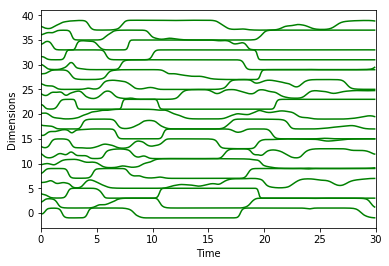

In [9]:
# Generate some target data by running an ESN, and just grabbing hidden 
# dimensions as the targets of the FORCE trained network.

g = 1.8  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
m = 20   # Number of targets, and thus outputs for trained ESN.

#data_seed = onp.random.randint(0, 10000000)
data_seed = 7868221
print("Data seed: %d" % (data_seed))
key = random.PRNGKey(data_seed)
data_params = random_esn_params(key, u, n, m, g=g)
h_t, z_t = esn_run_jax_jit(data_params, x_t)

f_t = h_t[:,0:m] # This will be the training data for the trained ESN
plt.plot(time, f_t + 2*onp.arange(0, m), 'g');
plt.xlim((0, T))
plt.ylabel('Dimensions')
plt.xlabel('Time');

Params seed 9187337


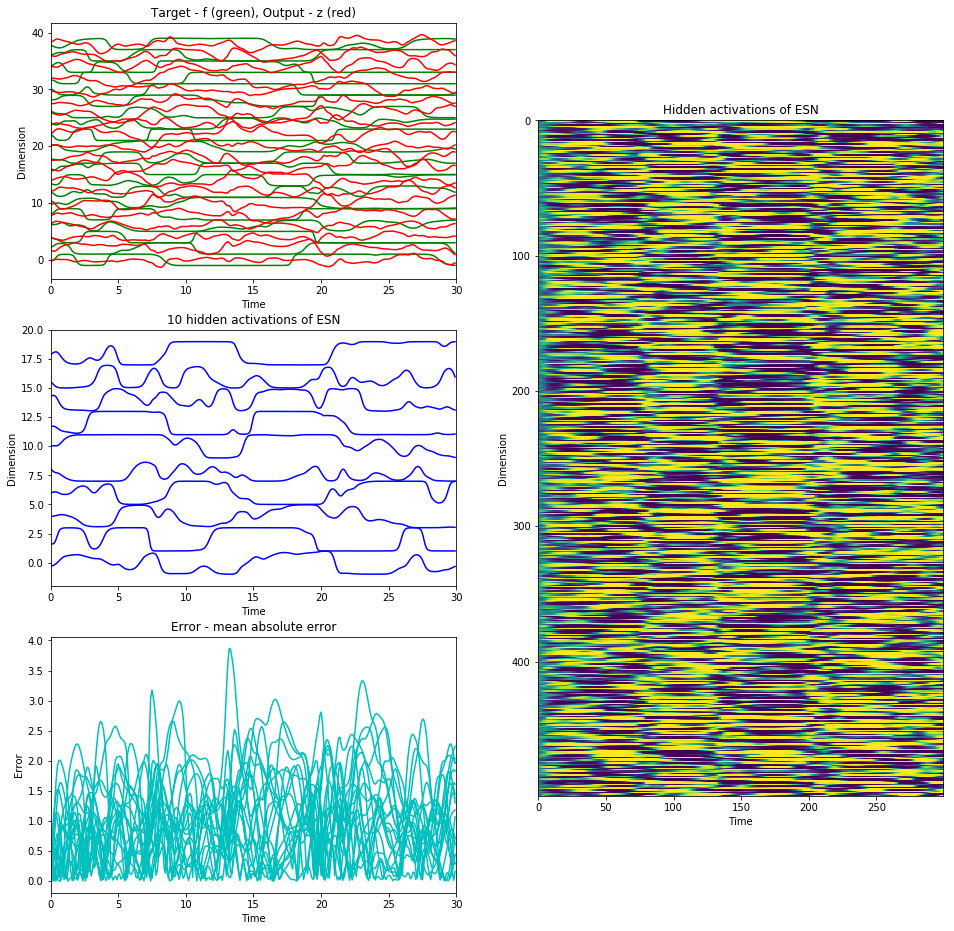

In [10]:
# Create the ESN that will trained with FORCE learning.
g = 1.5  # Lower g value was shown to be good in the paper for training.
alpha = 1e0 # Initial learning rate for RLS

params_seed = onp.random.randint(0, 10000000)
print("Params seed %d" %(params_seed))
key = random.PRNGKey(params_seed)
init_params = random_esn_params(key, u, n, m, g=g)
fparams = new_force_params(n, alpha=alpha)

# Run the untrained ESN to get a look it.
h_t, z_t = esn_run_jax_jit(init_params, x_t)
print_force(init_params, fparams, x_t, h_t, z_t, f_t, T)

In [231]:
# Copy the params to the ones we will be training.
params = dict.copy(init_params)

In [232]:
# Train the ESN, you can train all at once by setting ntraining to 
# about 15, or you can set it to 1 and watch it, by plotting in the 
# next cell.

# Again, the first time through, this takes a few minutes, afterwards
# a few tens of milliseconds.
ntraining = 15
for train_idx in range(ntraining):
  params, fparams, h_t, z_t = esn_train_jax_jit(params, fparams, x_t, f_t)

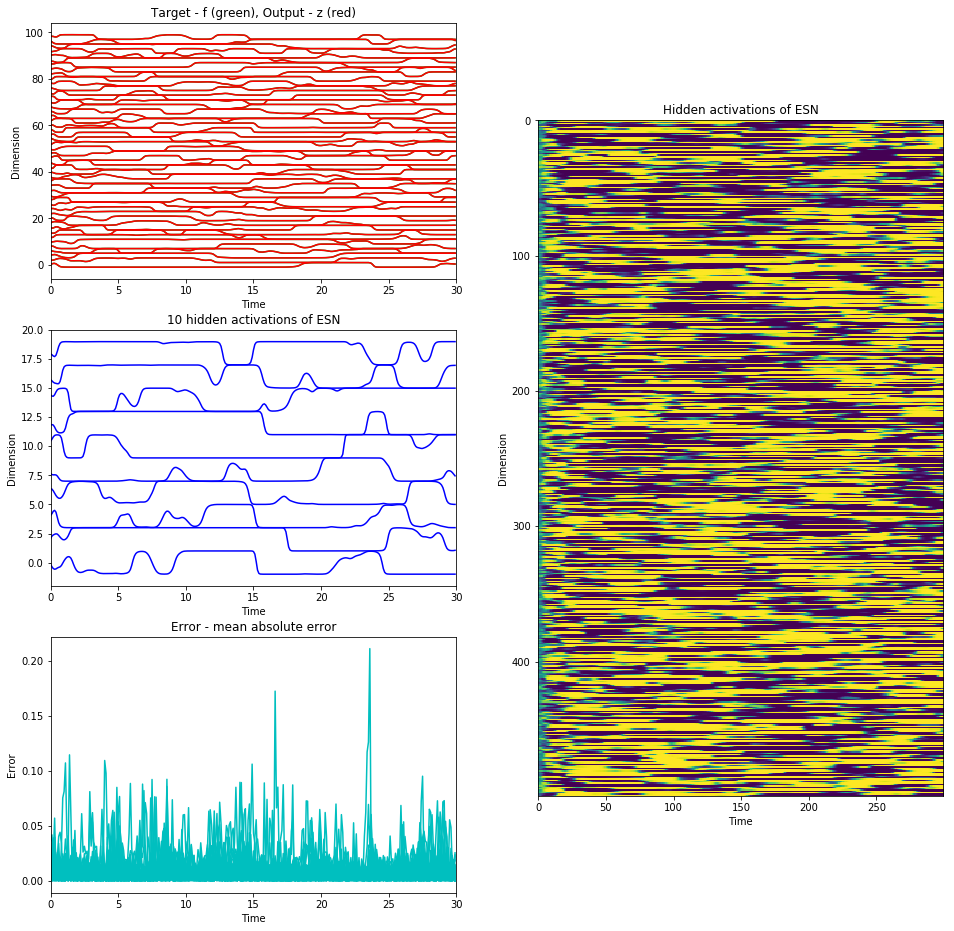

In [233]:
h_t, z_t = esn_run_jax_jit(params, x_t)
print_force(params, fparams, x_t, h_t, z_t, f_t, T)

# Implement FORCE myself

In [467]:
# Basic parameters of the Echostate networks
key = random.PRNGKey(0)

T = 30              # total time
u = 1               # number of inputs (didn't bother to set up zero, just put in zeros)
n = 500             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

In [472]:
# TEACHER
g = 1.8  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
m = 20   # Number of targets, and thus outputs for trained ESN.

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,n) * pfactor
wF = onp.random.randn(n,m) * ffactor
dtdivtau = dt/tau

# params = random_esn_params(key, u, n, m, g=g)
# a = params['a0']
# h = np.tanh(a)
# wO = params['wO']
# z = np.dot(wO, h)

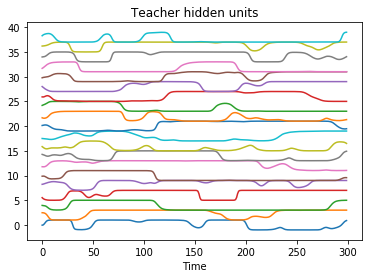

In [475]:
# RUN TEACHER
h_t = []
z_t = []
a = onp.copy(a0)
h = np.tanh(a)
z = np.dot(wO, h)
for _ in tqdm(time):
    # Run ESN
    dadt = -a + np.dot(wR, h) + np.dot(wF, z)
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    z = np.dot(wO, h)

    h_t.append(h)
    z_t.append(z)
h_t = np.stack(h_t)
z_t = np.stack(z_t)

# Set target 
f_t = h_t[:,:m]

plt.plot(h_t[:,:m] + 2*np.arange(m));
plt.title('Teacher hidden units');
plt.xlabel('Time');

In [476]:
# STUDENT
g = 1.5  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
n = 500
alpha = 1e0

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,n) * pfactor
wF = onp.random.randn(n,m) * ffactor
dtdivtau = dt/tau

In [477]:
# Initialize covariance matrix
P = np.eye(n)*alpha

errs = []
n_train = 15
for _ in tqdm(range(n_train)):
    a = onp.copy(a0)
    h = np.tanh(a)
    z = np.dot(wO, h)

    h_t = []
    z_t = []
    for f in f_t:
        # Run ESN
        dadt = -a + np.dot(wR, h) + np.dot(wF, z)
        a = a + dtdivtau * dadt
        h = np.tanh(a)
        z = np.dot(wO, h)

        h_t.append(h)
        z_t.append(z)

        # RLS
        # update inverse correlation matrix
        k = np.expand_dims(np.dot(P, h), axis=1)
        hPh = np.dot(h.T, k)
        c = 1.0/(1.0 + hPh)
        P = P - np.dot(k*c, k.T)

        # update the output weights
        e = np.atleast_2d(z-f)
        dw = np.dot(-c*k, e).T
        wO = wO + dw
    h_t = np.stack(h_t)
    z_t = np.stack(z_t)
    
    err = np.sum((z_t-f_t)**2)
    errs.append(err)

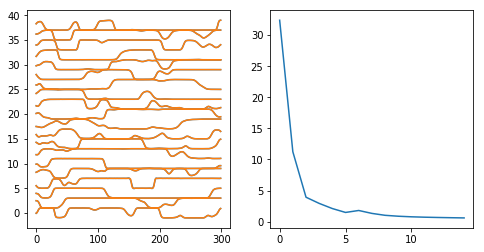

In [478]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(z_t[:,:20] + 2*np.arange(20), c='C0')
plt.plot(f_t[:,:20] + 2*np.arange(20), c='C1');
plt.subplot(122)
plt.plot(errs);

In [479]:
h_t = []
z_t = []
a = onp.copy(a0)
h = np.tanh(a)
z = np.dot(wO, h)
for f in tqdm(f_t):
    # Run ESN
    dadt = -a + np.dot(wR, h) + np.dot(wF, z)
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    z = np.dot(wO, h)

    h_t.append(h)
    z_t.append(z)
h_t = np.stack(h_t)
z_t = np.stack(z_t)

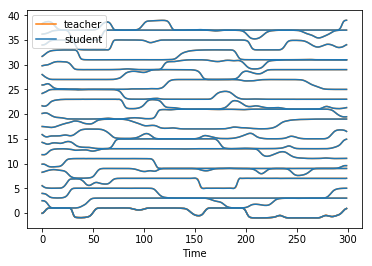

In [484]:
plt.plot(f_t[:,0], c='C1',label='teacher')
plt.plot(z_t[:,0], c='C0', label='student');
plt.plot(f_t[:,:20] + 2*np.arange(20), c='C1')
plt.plot(z_t[:,:20] + 2*np.arange(20), c='C0');
plt.xlabel('Time')
plt.legend(['teacher','student']);

## Expander

In [491]:
# STUDENT
M = 1000
g = 1.5  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
alpha = 1e0

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(M)
mfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,M) * pfactor
wF = onp.random.randn(n,m) * ffactor
wM = onp.random.randn(M,n) * mfactor
dtdivtau = dt/tau

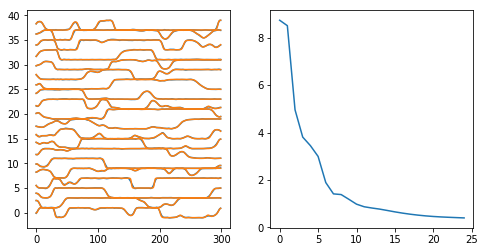

In [492]:
P = np.eye(M)*1e-2

n_train = 25
errs = []
for _ in tqdm(range(n_train)):
    a = onp.copy(a0)
#     h = np.tanh(a)
    h = a
    b = wM@h
    hM = (b>0).astype(np.float32)
    z = np.dot(wO, b)

    h_t = []
    z_t = []
    for f in f_t:
        # Run ESN
        dadt = -a + np.dot(wR, h) + np.dot(wF, z)
        a = a + dtdivtau * dadt
        h = np.tanh(a)
        b = wM@h
        hM = np.tanh(b)
        z = np.dot(wO, b)

        h_t.append(h)
        z_t.append(z)

        # RLS
        # update inverse correlation matrix
        k = np.expand_dims(np.dot(P, hM), axis=1)
        hPh = np.dot(hM.T, k)
        c = 1.0/(1.0 + hPh)
        P = P - np.dot(k*c, k.T)

        # update the output weights
        e = np.atleast_2d(z-f)
        dw = np.dot(-c*k, e).T
        wO = wO + dw
    h_t = np.stack(h_t)
    z_t = np.stack(z_t)
    
    err = np.sum((z_t-f_t)**2) / T
    errs.append(err)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(z_t[:,:20] + 2*np.arange(20), c='C0')
plt.plot(f_t[:,:20] + 2*np.arange(20), c='C1');
plt.subplot(122)
plt.plot(errs);

In [493]:
h_t = []
z_t = []
a = onp.copy(a0)
h = np.tanh(a)
b = wM@h
hM = np.tanh(b)
z = np.dot(wO, b)

for f in tqdm(f_t):
    # Run ESN
    dadt = -a + np.dot(wR, h) + np.dot(wF, z)
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    b = wM@h
    hM = np.tanh(b)
    z = np.dot(wO, b)

    h_t.append(h)
    z_t.append(z)
h_t = np.stack(h_t)
z_t = np.stack(z_t)

Text(0.5, 1.0, 'Expander RNN (RLS)')

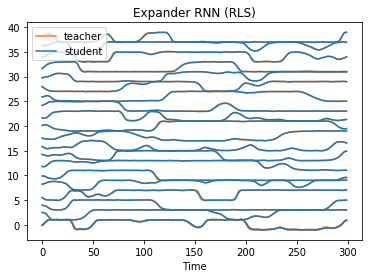

In [494]:
plt.plot(f_t[:,0], c='C1',label='teacher')
plt.plot(z_t[:,0], c='C0', label='student');
plt.plot(f_t[:,:20] + 2*np.arange(20), c='C1')
plt.plot(z_t[:,:20] + 2*np.arange(20), c='C0');
plt.xlabel('Time')
plt.legend(['teacher','student']);
plt.title('Expander RNN (RLS)')

# Hebbian learning

In [495]:
# Basic parameters of the Echostate networks
key = random.PRNGKey(0)

T = 30              # total time
u = 1               # number of inputs (didn't bother to set up zero, just put in zeros)
n = 500             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

In [498]:
# TEACHER
g = 1.8  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
m = 20   # Number of targets, and thus outputs for trained ESN.

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,n) * pfactor
wF = onp.random.randn(n,m) * ffactor
dtdivtau = dt/tau

# params = random_esn_params(key, u, n, m, g=g)
# a = params['a0']
# h = np.tanh(a)
# wO = params['wO']
# z = np.dot(wO, h)

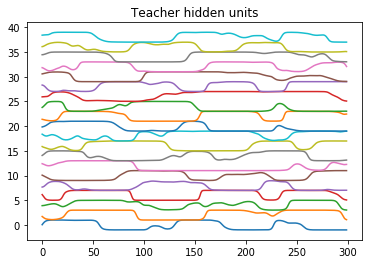

In [499]:
# RUN TEACHER
h_t = []
z_t = []
a = onp.copy(a0)
h = np.tanh(a)
z = np.dot(wO, h)
for _ in tqdm(time):
    # Run ESN
    dadt = -a + np.dot(wR, h) + np.dot(wF, z)
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    z = np.dot(wO, h)

    h_t.append(h)
    z_t.append(z)
h_t = np.stack(h_t)
z_t = np.stack(z_t)

# Set target 
f_t = h_t[:,:m]

plt.plot(h_t[:,:m] + 2*np.arange(m));
plt.title('Teacher hidden units');

In [542]:
# STUDENT
g = 1.5  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
alpha = 1e0

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,n) * pfactor
wF = onp.random.randn(n,m) * ffactor
dtdivtau = dt/tau

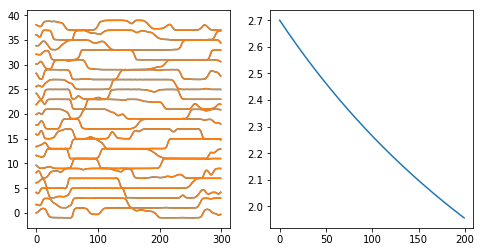

In [549]:
n_train = 200
eta = 1e-3
gamma = 1
errs = []
etas = []
for i in tqdm(range(n_train)):
    a = onp.copy(a0)
    h = np.tanh(a)
    z = np.dot(wO, h)

    h_t = []
    z_t = []
    for f in f_t:
        # Run ESN
        dadt = -a + np.dot(wR, h) + np.dot(wF, z)
        a = a + dtdivtau * dadt
        h = np.tanh(a)
        z = np.dot(wO, h)

        h_t.append(h)
        z_t.append(z)

        # HEBB
        e = f-z
        dw = np.outer(e,h)
        wO = wO + eta*dw
#         eta = eta + eta*(-eta + np.linalg.norm(e)**gamma/tau)
        etas.append(eta)
    h_t = np.stack(h_t)
    z_t = np.stack(z_t)
    
    err = np.sum((z_t-f_t)**2)
    errs.append(err)
    

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(z_t + 2*np.arange(m), c='C0')
plt.plot(f_t + 2*np.arange(m), c='C1');
plt.subplot(122)
plt.plot(errs)

In [550]:
h_t = []
z_t = []
a = onp.copy(a0)
h = np.tanh(a)
z = np.dot(wO, h)
for f in tqdm(f_t):
    # Run ESN
    dadt = -a + np.dot(wR, h) + np.dot(wF, z)
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    z = np.dot(wO, h)

    h_t.append(h)
    z_t.append(z)
h_t = np.stack(h_t)
z_t = np.stack(z_t)

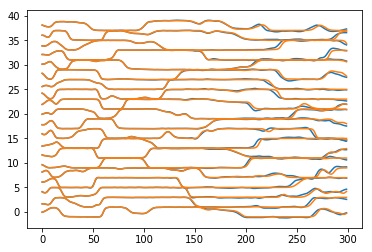

In [551]:
plt.plot(z_t + 2*np.arange(m), c='C0')
plt.plot(f_t + 2*np.arange(m), c='C1');

## Expander

In [518]:
# TEACHER
g = 1.8  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
m = 20   # Number of targets, and thus outputs for trained ESN.

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,n) * pfactor
wF = onp.random.randn(n,m) * ffactor
dtdivtau = dt/tau

# params = random_esn_params(key, u, n, m, g=g)
# a = params['a0']
# h = np.tanh(a)
# wO = params['wO']
# z = np.dot(wO, h)

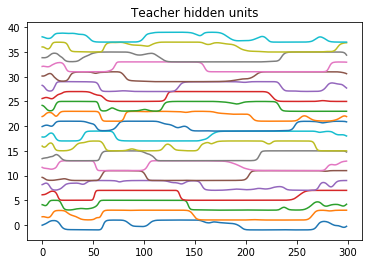

In [519]:
# RUN TEACHER
h_t = []
z_t = []
a = onp.copy(a0)
h = np.tanh(a)
z = np.dot(wO, h)
for _ in tqdm(time):
    # Run ESN
    dadt = -a + np.dot(wR, h) + np.dot(wF, z)
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    z = np.dot(wO, h)

    h_t.append(h)
    z_t.append(z)
h_t = np.stack(h_t)
z_t = np.stack(z_t)

# Set target 
f_t = h_t[:,:m]

plt.plot(h_t[:,:m] + 2*np.arange(m));
plt.title('Teacher hidden units');

In [612]:
# STUDENT
M = 2000
g = 1.5  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
alpha = 1e0

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(M)
mfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,M) * pfactor
wF = onp.random.randn(n,m) * ffactor
wM = onp.random.randn(M,n) * mfactor
dtdivtau = dt/tau

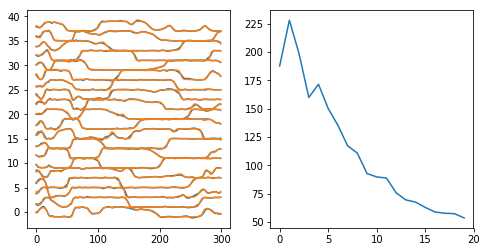

In [614]:
n_train = 20
errs = []
for _ in tqdm(range(n_train)):
    a = onp.copy(a0)
    h = np.tanh(a)
    b = wM@h
    hM = np.tanh(b)
    z = np.dot(wO, hM)

    h_t = []
    z_t = []
    for f in f_t:
        # Run ESN
        dadt = -a + np.dot(wR, h) + np.dot(wF, z)
        a = a + dtdivtau * dadt
        h = np.tanh(a)
        b = wM@h
        hM = np.tanh(b)
        z = np.dot(wO, hM)

        h_t.append(h)
        z_t.append(z)

        # HEBB
        dw = np.outer(f-z,hM)
        wO = wO + 5e-4*dw
    h_t = np.stack(h_t)
    z_t = np.stack(z_t)
    
    err = np.sum((z_t-f_t)**2)
    errs.append(err)
    

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(z_t + 2*np.arange(m), c='C0')
plt.plot(f_t + 2*np.arange(m), c='C1');
plt.subplot(122)
plt.plot(errs);

In [528]:
h_t = []
z_t = []
a = onp.copy(a0)
h = np.tanh(a)
b = wM@h
hM = np.tanh(b)
z = np.dot(wO, b)

for f in tqdm(f_t):
    # Run ESN
    dadt = -a + np.dot(wR, h) + np.dot(wF, z)
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    b = wM@h
    hM = np.tanh(b)
    z = np.dot(wO, b)

    h_t.append(h)
    z_t.append(z)
h_t = np.stack(h_t)
z_t = np.stack(z_t)

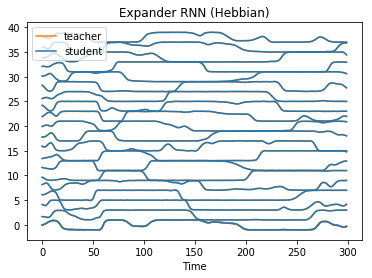

In [541]:
plt.plot(f_t[:,0], c='C1',label='teacher')
plt.plot(z_t[:,0], c='C0', label='student');
plt.plot(f_t[:,:20] + 2*np.arange(20), c='C1')
plt.plot(z_t[:,:20] + 2*np.arange(20), c='C0');
plt.xlabel('Time')
plt.legend(loc=2);
plt.title('Expander RNN (Hebbian)');

Notes to self:
Seems to be able to learn with many epochs of training. Not sure if it is better than un-expanded RNN.

## Compare vanilla RNN to expander

### First, vanilla

In [552]:
# STUDENT
g = 1.5  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
alpha = 1e0

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,n) * pfactor
wF = onp.random.randn(n,m) * ffactor
dtdivtau = dt/tau

Validating...


Validating...


Validating...


Validating...


Validating...


Validating...


Validating...


Validating...


Validating...


Validating...


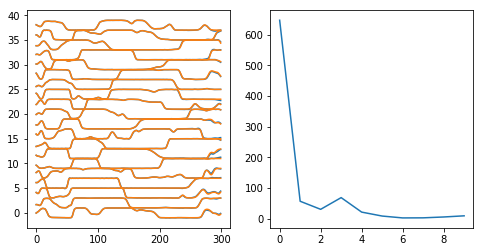

In [553]:
n_train = 1000
eta = 1e-3
gamma = 1
errs = []
etas = []
for i in tqdm(range(n_train)):
    a = onp.copy(a0)
    h = np.tanh(a)
    z = np.dot(wO, h)
    
    ## TRAIN
    for f in f_t:
        # Run ESN
        dadt = -a + np.dot(wR, h) + np.dot(wF, z)
        a = a + dtdivtau * dadt
        h = np.tanh(a)
        z = np.dot(wO, h)

        # HEBB
        e = f-z
        dw = np.outer(e,h)
        wO = wO + eta*dw
#         eta = eta + eta*(-eta + np.linalg.norm(e)**gamma/tau)
        etas.append(eta)    
    
    if i % 100 == 99:
        # VALIDATE
        print('Validating...')
        h_t = []
        z_t = []
        a = onp.copy(a0)
        h = np.tanh(a)
        z = np.dot(wO, h)
        for f in tqdm(f_t,leave=False):
            # Run ESN
            dadt = -a + np.dot(wR, h) + np.dot(wF, z)
            a = a + dtdivtau * dadt
            h = np.tanh(a)
            z = np.dot(wO, h)

            h_t.append(h)
            z_t.append(z)
        h_t = np.stack(h_t)
        z_t = np.stack(z_t)

        err = np.sum((z_t-f_t)**2)
        errs.append(err)
    

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(z_t + 2*np.arange(m), c='C0')
plt.plot(f_t + 2*np.arange(m), c='C1');
plt.subplot(122)
plt.plot(errs);

In [555]:
err_stash = errs

### Expander

In [615]:
# STUDENT
M = 2000
g = 1.5  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
alpha = 1e0

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(M)
mfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,M) * pfactor
wF = onp.random.randn(n,m) * ffactor
wM = onp.random.randn(M,n) * mfactor
dtdivtau = dt/tau

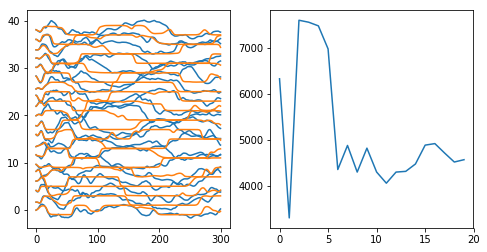

In [617]:
n_train = 1000
errs = []
for i in tqdm(range(n_train)):
    
    # TRAIN
    a = onp.copy(a0)
    h = np.tanh(a)
    b = wM@h
    hM = np.tanh(b)
    z = np.dot(wO, hM)
    for f in f_t:
        # Run ESN
        dadt = -a + np.dot(wR, h) + np.dot(wF, z)
        a = a + dtdivtau * dadt
        h = np.tanh(a)
        b = wM@h
        hM = np.tanh(b)
        z = np.dot(wO, hM)

        # HEBB
        dw = np.outer(f-z,hM)
        wO = wO + 5e-4*dw
        
    # VALIDATE
    if i % 50 == 49:
        h_t = []
        z_t = []
        a = onp.copy(a0)
        h = np.tanh(a)
        b = wM@h
        hM = np.tanh(b)
        z = np.dot(wO, b)

        for f in f_t:
            # Run ESN
            dadt = -a + np.dot(wR, h) + np.dot(wF, z)
            a = a + dtdivtau * dadt
            h = np.tanh(a)
            b = wM@h
            hM = np.tanh(b)
            z = np.dot(wO, b)

            h_t.append(h)
            z_t.append(z)
        h_t = np.stack(h_t)
        z_t = np.stack(z_t)

        err = np.sum((z_t-f_t)**2)
        errs.append(err)
    

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(z_t + 2*np.arange(m), c='C0')
plt.plot(f_t + 2*np.arange(m), c='C1');
plt.subplot(122)
plt.plot(errs);

In [596]:
h_t = []
z_t = []
a = onp.copy(a0)
h = np.tanh(a)
b = wM@h
hM = np.tanh(b)
z = np.dot(wO, b)

for f in tqdm(f_t):
    # Run ESN
    dadt = -a + np.dot(wR, h) + np.dot(wF, z)
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    b = wM@h
    hM = np.tanh(b)
    z = np.dot(wO, b)

    h_t.append(h)
    z_t.append(z)
h_t = np.stack(h_t)
z_t = np.stack(z_t)

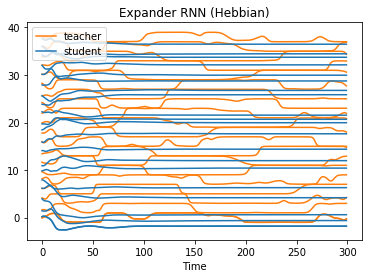

In [597]:
plt.plot(f_t[:,0], c='C1',label='teacher')
plt.plot(z_t[:,0], c='C0', label='student');
plt.plot(f_t[:,:20] + 2*np.arange(20), c='C1')
plt.plot(z_t[:,:20] + 2*np.arange(20), c='C0');
plt.xlabel('Time')
plt.legend(loc=2);
plt.title('Expander RNN (Hebbian)');

# Repertoire
Can we FORCE learn mutliple dynamics from different initial conditions?

In [618]:
# Basic parameters of the Echostate networks
key = random.PRNGKey(0)

T = 30              # total time
u = 10               # number of inputs (didn't bother to set up zero, just put in zeros)
n = 500             # size of the reservoir in the ESN
tau = 1.0           # neuron time constant
dt = tau / 10.0     # Euler integration step
time = np.arange(0, T, dt) # all time
ntime = time.shape[0]      # the number of time steps

In [624]:
# TEACHER
g = 1.8  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
m = 20   # Number of targets, and thus outputs for trained ESN.

key, skeys = keygen(key, 5)
hscale = 0.25
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

a0 = onp.random.randn(n) * hscale     # initial activation
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,n) * pfactor
wF = onp.random.randn(n,m) * ffactor
dtdivtau = dt/tau

In [625]:
# RUN TEACHER

n_patterns = 5
F = []
for _ in tqdm(range(n_patterns)):
    h_t = []
    z_t = []
    a = onp.random.randn(n) * hscale     # New random IC
    h = np.tanh(a)
    z = np.dot(wO, h)
    for _ in time:
        # Run ESN
        dadt = -a + np.dot(wR, h) + np.dot(wF, z)
        a = a + dtdivtau * dadt
        h = np.tanh(a)
        z = np.dot(wO, h)

        h_t.append(h)
        z_t.append(z)
    h_t = np.stack(h_t)
    z_t = np.stack(z_t)

    # Set target 
    f_t = h_t[:,:m]
    F.append(f_t)

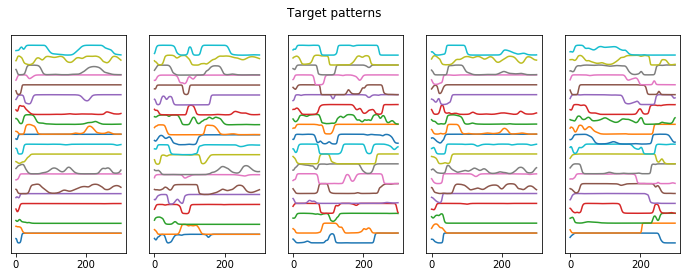

In [626]:
plt.figure(figsize=(12,4))
plt.suptitle('Target patterns')
for i,f_t in enumerate(F):
    plt.subplot(1,5,i+1)
    plt.plot(f_t+ 2*np.arange(m));
    plt.yticks([], [])

In [391]:
# STUDENT
g = 1.5  # Recurrent scaling of the data ESN, gives how wild the dynamics are.
alpha = 1e0

key, skeys = keygen(key, 5)
hscale = 0.25
ifactor = 1.0 / np.sqrt(u)
hfactor = g / np.sqrt(n)
pfactor = 1.0 / np.sqrt(n)
ffactor = 1.0 # Feedback factor, keep at 1 for now.

A = []
X = []
for i in range(n_patterns):
    a0 = onp.random.randn(n) * hscale     # initial activation
    x = onp.random.randn(u) * hscale      # New random input
    A.append(a0)
    X.append(x)
wI = onp.random.randn(n,u) * ifactor
wR = onp.random.randn(n,n) * hfactor
wO = onp.random.randn(m,n) * pfactor
wF = onp.random.randn(n,m) * ffactor
dtdivtau = dt/tau

In [392]:
# Initialize covariance matrix
P = np.eye(n)*alpha

errs = []
n_train = 5
for _ in tqdm(range(n_train)):
    for i in range(n_patterns):
        a = A[i]
        x = X[i]
        h = np.tanh(a)
        z = np.dot(wO, h)

        h_t = []
        z_t = []
        for f in f_t:
            # Run ESN
            dadt = -a + np.dot(wR, h) + np.dot(wF, z) + wI@x
            a = a + dtdivtau * dadt
            h = np.tanh(a)
            z = np.dot(wO, h)

            h_t.append(h)
            z_t.append(z)

            # RLS
            # update inverse correlation matrix
            k = np.expand_dims(np.dot(P, h), axis=1)
            hPh = np.dot(h.T, k)
            c = 1.0/(1.0 + hPh)
            P = P - np.dot(k*c, k.T)

            # update the output weights
            e = np.atleast_2d(z-f)
            dw = np.dot(-c*k, e).T
            wO = wO + dw
        h_t = np.stack(h_t)
        z_t = np.stack(z_t)

        err = np.sum((z_t-f_t)**2)
        errs.append(err)

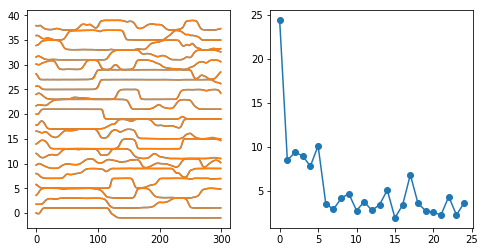

In [393]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.plot(z_t[:,:20] + 2*np.arange(20), c='C0')
plt.plot(f_t[:,:20] + 2*np.arange(20), c='C1');
plt.subplot(122)
plt.plot(errs, 'o-');

In [397]:
Z = []
for i in tqdm(range(n_patterns)):
    h_t = []
    z_t = []
    a = A[i]
    x = X[i]
    h = np.tanh(a)
    z = np.dot(wO, h)
    for f in f_t:
        # Run ESN
        dadt = -a + np.dot(wR, h) + np.dot(wF, z) + wI@x
        a = a + dtdivtau * dadt
        h = np.tanh(a)
        z = np.dot(wO, h)

        h_t.append(h)
        z_t.append(z)
    h_t = np.stack(h_t)
    z_t = np.stack(z_t)
    Z.append(z_t)

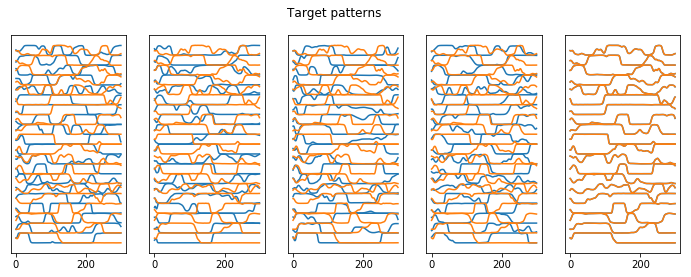

In [398]:
plt.figure(figsize=(12,4))
plt.suptitle('Target patterns')
for i,(f_t,z_t) in enumerate(zip(F,Z)):
    plt.subplot(1,5,i+1)
    plt.plot(f_t+ 2*np.arange(m), c='C0');
    plt.plot(z_t+ 2*np.arange(m), c='C1');
    plt.yticks([], [])

In [373]:
zi = []
for z_t in Z:
    zi.append(z_t[0])

In [374]:
zi = np.stack(zi)

In [375]:
zi.shape

(5, 20)

In [377]:
zi[0]@zi[1]/np.linalg.norm(zi[0])/np.linalg.norm(zi[1])

DeviceArray(0.7602327, dtype=float32)

In [372]:
z_t.shape

(300, 20)

# Beer Barak

In [47]:
@jit
def RNN_step(a,h,u,z,w_out,dtdivtau):
    dadt = -a + w_in*u + J@h + w_fb@z
    a = a + dtdivtau * dadt
    h = np.tanh(a)
    z = w_out@h
    
    return a,h,z

In [48]:
@jit 
def RLS(P,h,z,f,w_out):
    # RLS    
    Ph = P@h
    hPh = h.T@Ph
    c = 1.0/(1.0 + hPh)
    P = P - c*np.outer(Ph,Ph)

    e = z-f
    dw = -e[:,None]*(P@h)
    w_out = w_out + dw
    return P, w_out

In [82]:
@jit 
def RLS(P,h,z,f,w_out):
    # update inverse correlation matrix
    k = np.expand_dims(np.dot(P, h), axis=1)
    hPh = np.dot(h.T, k)
    c = 1.0/(1.0 + hPh)
    P = P - np.dot(k*c, k.T)

    # update the output weights
    e = np.atleast_2d(z-f)
    dw = np.dot(-c*k, e).T
    w_out = w_out + dw
    
    return P, w_out 

## Memory task

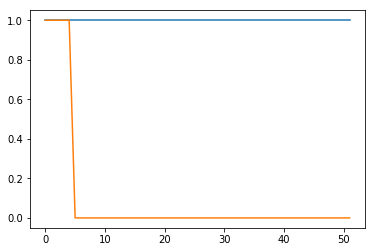

In [7]:
dt = 1e-1
def construct_input(amp,delay):
    t_pres = int(0.5/dt)
    t_delay = np.int16(delay/dt)
    
    u_pres = amp*np.ones(t_pres)
    u_delay = np.zeros(t_delay)
    u = np.concatenate([u_pres,u_delay])
    
    f = amp*np.ones(t_pres+t_delay)

    return u,f

construct_input = jit(construct_input,static_argnums=1)

delay = random.uniform(0.5,6)
u,f = construct_input(1, delay)
plt.plot(f)
plt.plot(u);

In [ ]:
tau = 1e-1
n_trials = 500
alpha = 10
output_dim = 1
dtdivtau = dt/tau

N = 500
g = 1.2

# Initialize P
P = np.eye(N) / alpha

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
w_in = random.uniform(-1,1,N)
w_fb = random.uniform(-1,1,(N,output_dim))
w_out = np.zeros((output_dim,N))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

amps = random.uniform(1,5,9)
delays = np.device_put(random.uniform(0.5,6,n_trials+10))

errs = []
for trial in tqdm(range(n_trials)):
    # Train
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[trial])
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        # RLS
        P,w_out = RLS(P,h,z,f,w_out)
        
    # Validate
    if trial % 5 == 4:
        zs = []
        fs_all = []
        for i in range(10):
            amp = random.choice(amps)
            us,fs = construct_input(amp,delays[i])
            fs_all.append(fs)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
                zs.append(z)
        zs = np.concatenate(zs)
        fs_all = np.concatenate(fs_all)
        err = np.mean(np.abs(zs-fs_all))
        errs.append(err)

# Final validation
zs = []
fs_all = []
us_all = []
for i in range(10):
    amp = random.choice(amps)
    us,fs = construct_input(amp,delays[i])
    fs_all.append(fs)
    us_all.append(us)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        zs.append(z)
zs = np.concatenate(zs)
fs_all = np.concatenate(fs_all)
us_all = np.concatenate(us_all)

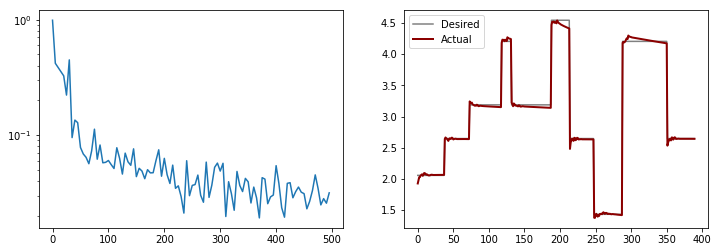

In [148]:
plt.figure(figsize=(12,4))
plt.subplot(121)
T = np.arange(len(errs))*5
plt.plot(T,errs)
plt.yscale('log')

plt.subplot(122)
plt.plot(fs_all, c='grey', label='Desired')
plt.plot(zs, c='darkred', linewidth=2, label='Actual');
plt.legend();

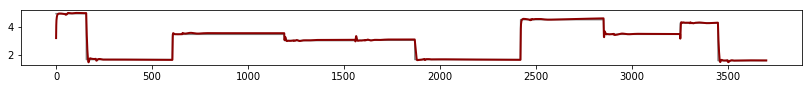

In [225]:
plt.figure(figsize=(14,1))
# plt.plot(us_all);
plt.plot(fs_all, c='grey')
plt.plot(zs, c='darkred', linewidth=2);

## Frequency generator task

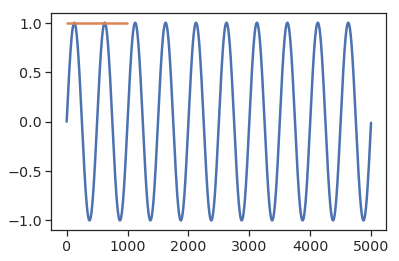

In [84]:
dt = 2e-3
def build_frequency(f):
    period = int(1/(dt*f))

    # Inputs
    u0 = f*np.ones(2*period)
    u1 = np.zeros(10*period)
    u = np.concatenate([u0,u1])

    # Target outputs
    z0 = np.zeros((2,2*period))
    T = np.arange(10*period)
    zsin = np.sin(2*np.pi*T*f*dt)
    zcos = np.cos(2*np.pi*T*f*dt)
    z1 = np.vstack([zsin,zcos])
    f = np.hstack([z0,z1]).T
    return u0,u1,z1.T


u0,u1,f = build_frequency(1)
plt.plot(f[:,0])
plt.plot(u0);

In [86]:
tau = 1e-1
n_trials = 2000
alpha = 10
output_dim = 2
dtdivtau = dt/tau
val_freq = 5          # validate after this many trials

N = 2000
g = 1.2

# Initialize P
P = np.eye(N) / alpha

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
# w_in = random.uniform(-1,1,N)
w_in = random.randn(N)
w_fb = random.uniform(-1,1,(N,output_dim))
w_out = np.zeros((output_dim,N))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

freqs = random.uniform(0.2,1.1,10)

errs = []
for trial in tqdm(range(n_trials)):
    
    # Train
    freq = random.choice(freqs)
    us0,us,fs = build_frequency(freq)
    
    for u in us0:
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
    
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        # RLS
        P,w_out = RLS(P,h,z,f,w_out)
        
    # Validate
    if trial % val_freq == val_freq-1:
        zs = []
        fs_all = []
        for i in range(5):
            freq = random.choice(freqs)
            us0,us,fs = build_frequency(freq)
            fs_all.append(fs)
            for u in us0:
                # Run RNN
                a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
                zs.append(z)
        zs = np.vstack(zs)
        fs_all = np.concatenate(fs_all)
        err = np.mean(np.abs(zs-fs_all))
        errs.append(err)
        print('Err: ' + str(err))

# Final validation
zs = []
fs_all = []
us_all = []
for i in range(2):
    freq = random.choice(freqs)
    us0,us,fs = build_frequency(freq)
    fs_all.append(fs)
    us_all.append(us)
    for u in us0:
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        zs.append(z)
zs = np.vstack(zs)
fs_all = np.concatenate(fs_all)
us_all = np.concatenate(us_all)

Err: 0.6770007
Err: 0.68241304
Err: 0.27699324
Err: 0.4756459
Err: 0.23518051
Err: 0.55885303
Err: 0.4301747
Err: 0.3770895
Err: 0.649752
Err: 0.39233825
Err: 0.4000409
Err: 0.40060508
Err: 0.4002197
Err: 0.4928194
Err: 0.5398666
Err: 0.25004438
Err: 0.31408277
Err: 0.2630927
Err: 0.27089798
Err: 0.21570183
Err: 0.28174186
Err: 0.11514392
Err: 0.6128625
Err: 0.13492009
Err: 0.3002059
Err: 0.31518558
Err: 0.13556671
Err: 0.38836458
Err: 0.16088118
Err: 0.1442244
Err: 0.31980422
Err: 0.3535738
Err: 0.4012165
Err: 0.16023679
Err: 0.28363833
Err: 0.25128844
Err: 0.22849959
Err: 0.10161224
Err: 0.20643085
Err: 0.1953251
Err: 0.17018056
Err: 0.20557837
Err: 0.26351103
Err: 0.1823808
Err: 0.119477525
Err: 0.21219559
Err: 0.1894144
Err: 0.26542372
Err: 0.2569404
Err: 0.14460638
Err: 0.0944582
Err: 0.3302139
Err: 0.12502883
Err: 0.19690865
Err: 0.18723497
Err: 0.15061314
Err: 0.0455004
Err: 0.13076274
Err: 0.18081939
Err: 0.10227371
Err: 0.17447163
Err: 0.15794635
Err: 0.15139535
Err: 0.1119957

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



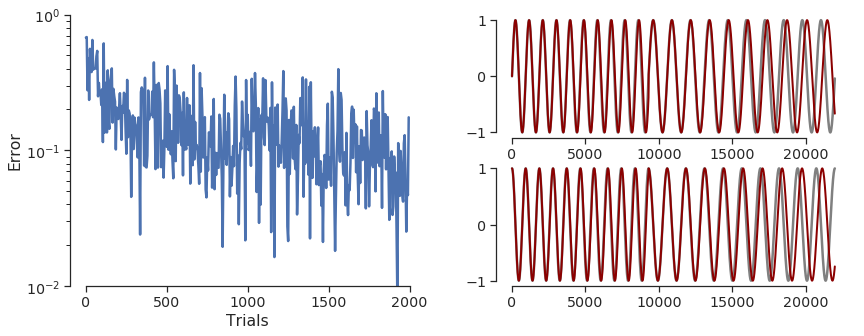

In [87]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[:,0])
T = np.arange(len(errs))*val_freq
plt.plot(T,errs)
plt.yscale('log')
plt.ylim([1e-2,1])
plt.ylabel('Error')
plt.xlabel('Trials')

ax2 = fig.add_subplot(gs[0,1])
with sns.axes_style('white'):
    plt.plot(fs_all[:,0], c='grey', label='Desired')
    plt.plot(zs[:,0], c='darkred', linewidth=2, label='Actual');
    
#     plt.legend();
ax3 = fig.add_subplot(gs[1,1])
with sns.axes_style('white'):
    plt.plot(fs_all[:,1], c='grey', label='Desired')
    plt.plot(zs[:,1], c='darkred', linewidth=2, label='Actual');
    sns.despine(trim=True)

In [88]:

# Final validation
zs = []
fs_all = []
us_all = []
for i in range(2):
    freq = random.choice(freqs)
    us0,us,fs = build_frequency(freq)
    fs_all.append(fs)
    us_all.append(us)
    for u in us0:
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        zs.append(z)
zs = np.vstack(zs)
fs_all = np.concatenate(fs_all)
us_all = np.concatenate(us_all)

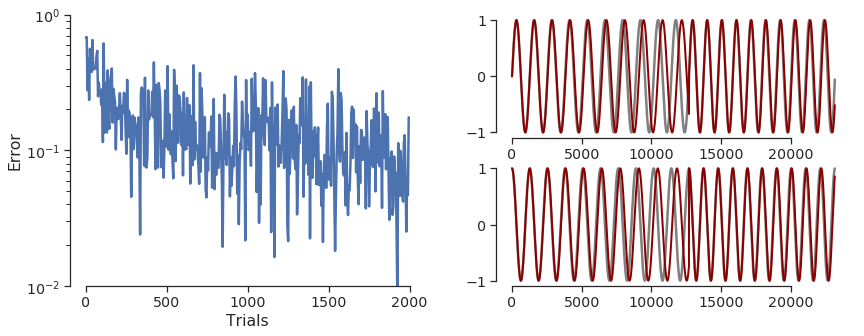

In [89]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[:,0])
T = np.arange(len(errs))*val_freq
plt.plot(T,errs)
plt.yscale('log')
plt.ylim([1e-2,1])
plt.ylabel('Error')
plt.xlabel('Trials')

ax2 = fig.add_subplot(gs[0,1])
with sns.axes_style('white'):
    plt.plot(fs_all[:,0], c='grey', label='Desired')
    plt.plot(zs[:,0], c='darkred', linewidth=2, label='Actual');
    
#     plt.legend();
ax3 = fig.add_subplot(gs[1,1])
with sns.axes_style('white'):
    plt.plot(fs_all[:,1], c='grey', label='Desired')
    plt.plot(zs[:,1], c='darkred', linewidth=2, label='Actual');
    sns.despine(trim=True)

In [61]:
zs = []
fs_all = []
us_all = []
for i in range(2):
    freq = random.choice(freqs)
    us,fs = build_frequency(freq)
    fs_all.append(fs)
    us_all.append(us)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        zs.append(z)
zs = np.vstack(zs)
fs_all = np.concatenate(fs_all)
us_all = np.concatenate(us_all)

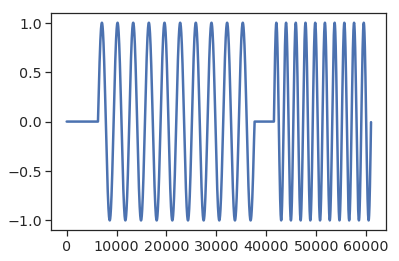

In [76]:
plt.plot(fs_all[:,0])

Text(0.5, 0, 'T')

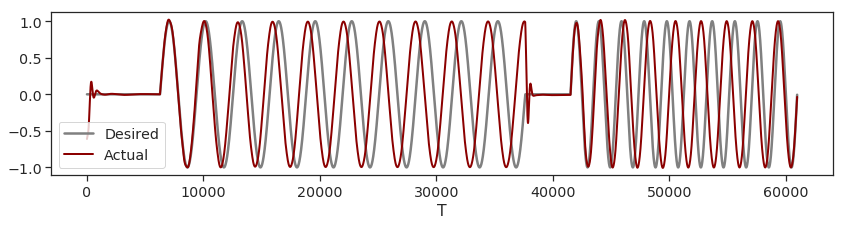

In [69]:
plt.figure(figsize=(14,3))
# plt.plot(us_all);
plt.plot(fs_all[:,0], c='grey', label='Desired')
plt.plot(zs[:,0], c='darkred', linewidth=2, label='Actual');
plt.legend();
plt.xlabel('T')

Text(0.5, 0, 'T')

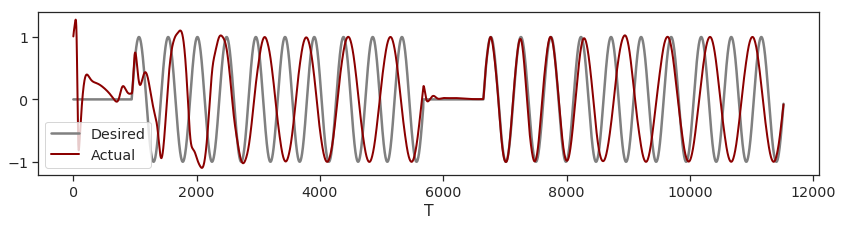

In [56]:
plt.figure(figsize=(14,3))
# plt.plot(us_all);
plt.plot(fs_all[:,0], c='grey', label='Desired')
plt.plot(zs[:,0], c='darkred', linewidth=2, label='Actual');
plt.legend();
plt.xlabel('T')

Text(0.5, 0, 'T')

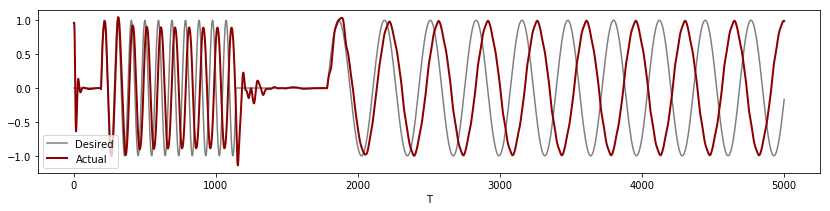

In [205]:
plt.figure(figsize=(14,3))
# plt.plot(us_all);
plt.plot(fs_all[:,0], c='grey', label='Desired')
plt.plot(zs[:,0], c='darkred', linewidth=2, label='Actual');
plt.legend();
plt.xlabel('T')

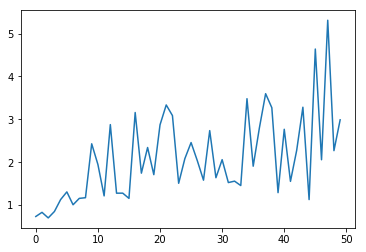

In [147]:
plt.plot(errs)

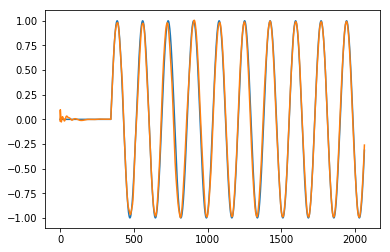

In [148]:
plt.plot(fs[:,0])
plt.plot(zs[:,0]);

In [149]:
zs = []
fs_all = []
for _ in range(3):
    freq = random.choice(freqs)
    us,fs = build_frequency(freq)
    fs = fs.T
    fs_all.append(fs)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        zs.append(z)
zs = np.stack(zs)
fs_all = np.vstack(fs_all)

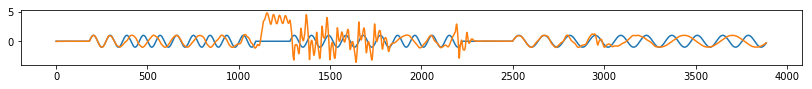

In [150]:
plt.figure(figsize=(14,1))
plt.plot(fs_all[:,0])
plt.plot(zs[:,0]);

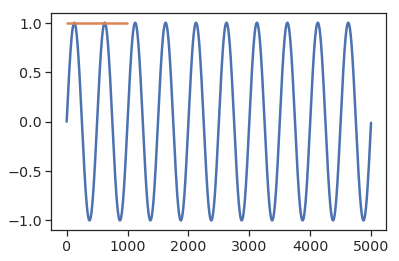

In [216]:
dt = 2e-3
def build_frequency(f):
    period = int(1/(dt*f))

    # Inputs
    u0 = f*np.ones(2*period)
    u1 = np.zeros(10*period)
    u = np.concatenate([u0,u1])

    # Target outputs
    z0 = np.zeros((2,2*period))
    T = np.arange(10*period)
    zsin = np.sin(2*np.pi*T*f*dt)
    zcos = np.cos(2*np.pi*T*f*dt)
    z1 = np.vstack([zsin,zcos])
    f = np.hstack([z0,z1]).T
    return u0,u1,z1.T


u0,u1,f = build_frequency(1)
plt.plot(f[:,0])
plt.plot(u0);

In [219]:
tau = 1e-1
n_trials = 10
alpha = 10
output_dim = 2
dtdivtau = dt/tau
val_freq = 10          # validate after this many trials

N = 500
g = 1.2

# Initialize P
P = np.eye(N) / alpha

# Initialize weights
J = random.randn(N,N) * g / np.sqrt(N)
w_in = random.uniform(-1,1,N)
w_fb = random.uniform(-1,1,(N,output_dim))
w_out = np.zeros((output_dim,N))

# Initialize
a = np.zeros(N)
h = np.zeros(N)
z = np.zeros(output_dim)

freqs = random.uniform(0.2,1.1,1)

errs = []
for trial in tqdm(range(n_trials)):
    
    # Train
    freq = random.choice(freqs)
    us0,us,fs = build_frequency(freq)
    
    for u in us0:
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
    
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        # RLS
        P,w_out = RLS(P,h,z,f,w_out)
        
    # Validate
    if trial % val_freq == val_freq-1:
        zs = []
        fs_all = []
        for i in range(5):
            freq = random.choice(freqs)
            us0,us,fs = build_frequency(freq)
            fs_all.append(fs)
            for u in us0:
                # Run RNN
                a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
            for u,f in zip(us,fs):
                # Run RNN
                a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
                zs.append(z)
        zs = np.vstack(zs)
        fs_all = np.concatenate(fs_all)
        err = np.mean(np.abs(zs-fs_all))
        errs.append(err)
        print('Err: ' + str(err))

# Final validation
zs = []
fs_all = []
us_all = []
for i in range(2):
    freq = random.choice(freqs)
    us0,us,fs = build_frequency(freq)
    fs_all.append(fs)
    us_all.append(us)
    for u in us0:
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
    for u,f in zip(us,fs):
        # Run RNN
        a,h,z = RNN_step(a,h,u,z,w_out,dtdivtau)
        zs.append(z)
zs = np.vstack(zs)
fs_all = np.concatenate(fs_all)
us_all = np.concatenate(us_all)

Err: 0.0018422945



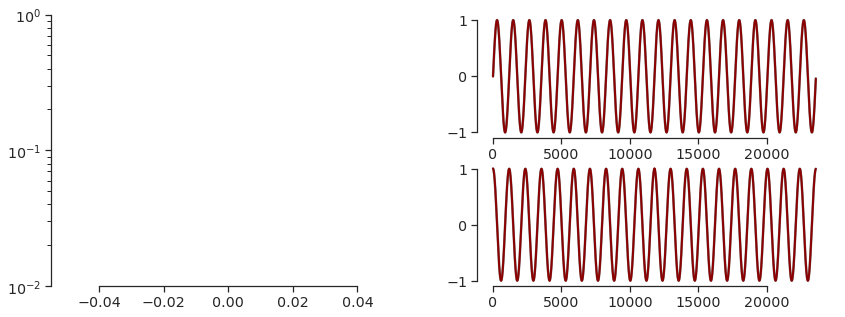

In [220]:
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[:,0])
T = np.arange(len(errs))*val_freq
plt.plot(T,errs)
plt.yscale('log')
plt.ylim([1e-2,1])

ax2 = fig.add_subplot(gs[0,1])
with sns.axes_style('white'):
    plt.plot(fs_all[:,0], c='grey', label='Desired')
    plt.plot(zs[:,0], c='darkred', linewidth=2, label='Actual');
#     plt.legend();
ax3 = fig.add_subplot(gs[1,1])
with sns.axes_style('white'):
    plt.plot(fs_all[:,1], c='grey', label='Desired')
    plt.plot(zs[:,1], c='darkred', linewidth=2, label='Actual');
    sns.despine(trim=True)